In [59]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.patches as patches

import pylab as plt
#!pip install --user gpy 
#!pip install --user plotly 

import GPy
from IPython.display import display

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, spectral_clustering, DBSCAN
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import utils

from importlib import reload


#GPy.plotting.change_plotting_library('plotly')
GPy.plotting.change_plotting_library('plotly_offline')

sns.set(color_codes=True)

# Gaussian Process course term project: Housing price prediction
Aarno Vuola, 355085
Martti Pankakoski, 
Ahti Kalervo,

# Intro


Housing price prediction based on historical data is difficult, as it is affected both by a multitude of house features and current economical situation. In this project we explore Helsinki municipality housing data and make predictions using Gaussian Process regression models. 

Our initial plan was to use GPs to fit and learn from the data, but this project ended up being a kind of learning experience of the pros and cons of gaussian processes and data analysis in general.


# Data

Our data set consists out of all the apartment deals made in Helsinki during the last 12 months, totaling 3432 rows. The raw data contains variables: apartment type, apartment size in $m^2$, neighborhood, price, number of rooms, year built, floor number, elevator, condition and neighborhood. We scarped the data from http://asuntojen.hintatiedot.fi/haku/. Also we enriched the data by adding location coordinates for each neighborhood and calculating the neighborhood's distance from Helsinki city center. Coordinates we fetched using Google maps API. 

### Preprocessing

For our analysis we needed to preprocess the raw dataset as the scraped raw data was not as such suitable for use. 

The following list shows the main preprocessing steps taken:


* String-valued binary choices were converted to numeric 1/0 binary features (such as the elevator 'yes/no' feature)

* Condition ('bad/ok/good') was encoded as ordinal range of 0,1,2 as it can be thought that higher value is better, meaning that ordinal encoding can be used

* Floor number was transformed into four distinct features:
     * Floor number
     * Binary variable bottom\_floor, true if floor number is one
     * Binary variable top\_floor, true if floor number is the same as amount of floors in a building
     * Floor fraction, floor number divided by the amount of floors

* Categorical variables such as house type were one-hot encoded

* Neighborhood string of the raw data was fed into Google Geocode API and resulting latitude and longitude recorded.

* Distance to city center was calculated by feeding the latitude and longitude of neighborhoods and Helsinki city center to a havesine function. This turned out to be a very important feature.

* Numerical features were left as-is.

Our preprocessed data set consisted of a total of 3327 rows with 17 features.

### Load data
Load raw data, drop some values missed in data preparation, drop unnecessary columns, show data head. See utils.load_data() function.

In [60]:
data, data_with_neighborhood = utils.load_data('data/cleaned_data2.csv')
data.head(5)

type_kt  type_rt  type_ok  elevator   price  price_per_square_meter  \
0        1        0        0         1  191050                   10055   
1        1        0        0         0  143000                    5789   
2        1        0        0         1  167000                    6680   
3        1        0        0         0  157000                    6181   
4        1        0        0         0  133000                    4926   

  number_of_rooms  square_meters  year  condition  floor_num top_floor  \
0               1           19.0  1929          2        5.0      True   
1               1           24.7  1957          1        3.0     False   
2               1           25.0  1940          1        6.0      True   
3               1           25.4  1951          1        1.0     False   
4               1           27.0  1961          2        2.0     False   

  bottom_floor  floor_frac        lat        lng  dist_center  
0        False    1.000000  60.167458  24.931075     0.485608  
1        False    0.750000  60.206704  24.871212     5.544540  
2        False    1.000000  60.188258  24.955949     2.270341  
3        False    0.250000  60.202747  24.905494     4.093763  
4        False    0.666667  60.212173  25.096109     9.939839

# Data exploration
In this section we explore the data to get a feel of the dataset and what variables affect the price of the flats.

### Plot variables
First we plot some variables to get a visual idea of the data. The goal of this project is to predict price per $m^2$, so most of the plots have that variable on y-axis. 

Some observations can immediately be made. Price/$m^2$ decreases with the distance from center, and distance from center increases per year. This is natural city develpment, where the apartments near the center are more expensive and most new apartments are built in newly developed areas further away from the center.

Price/$m^2$ also decreases with the number of rooms; This is also expected as huge apartments can't be as expensive per square meter as small one room apartments.

High coastline apartment prices are reflected in the price/$m^2$ per latitude plot. The highest prices are located near the sea, regardless of longitude.

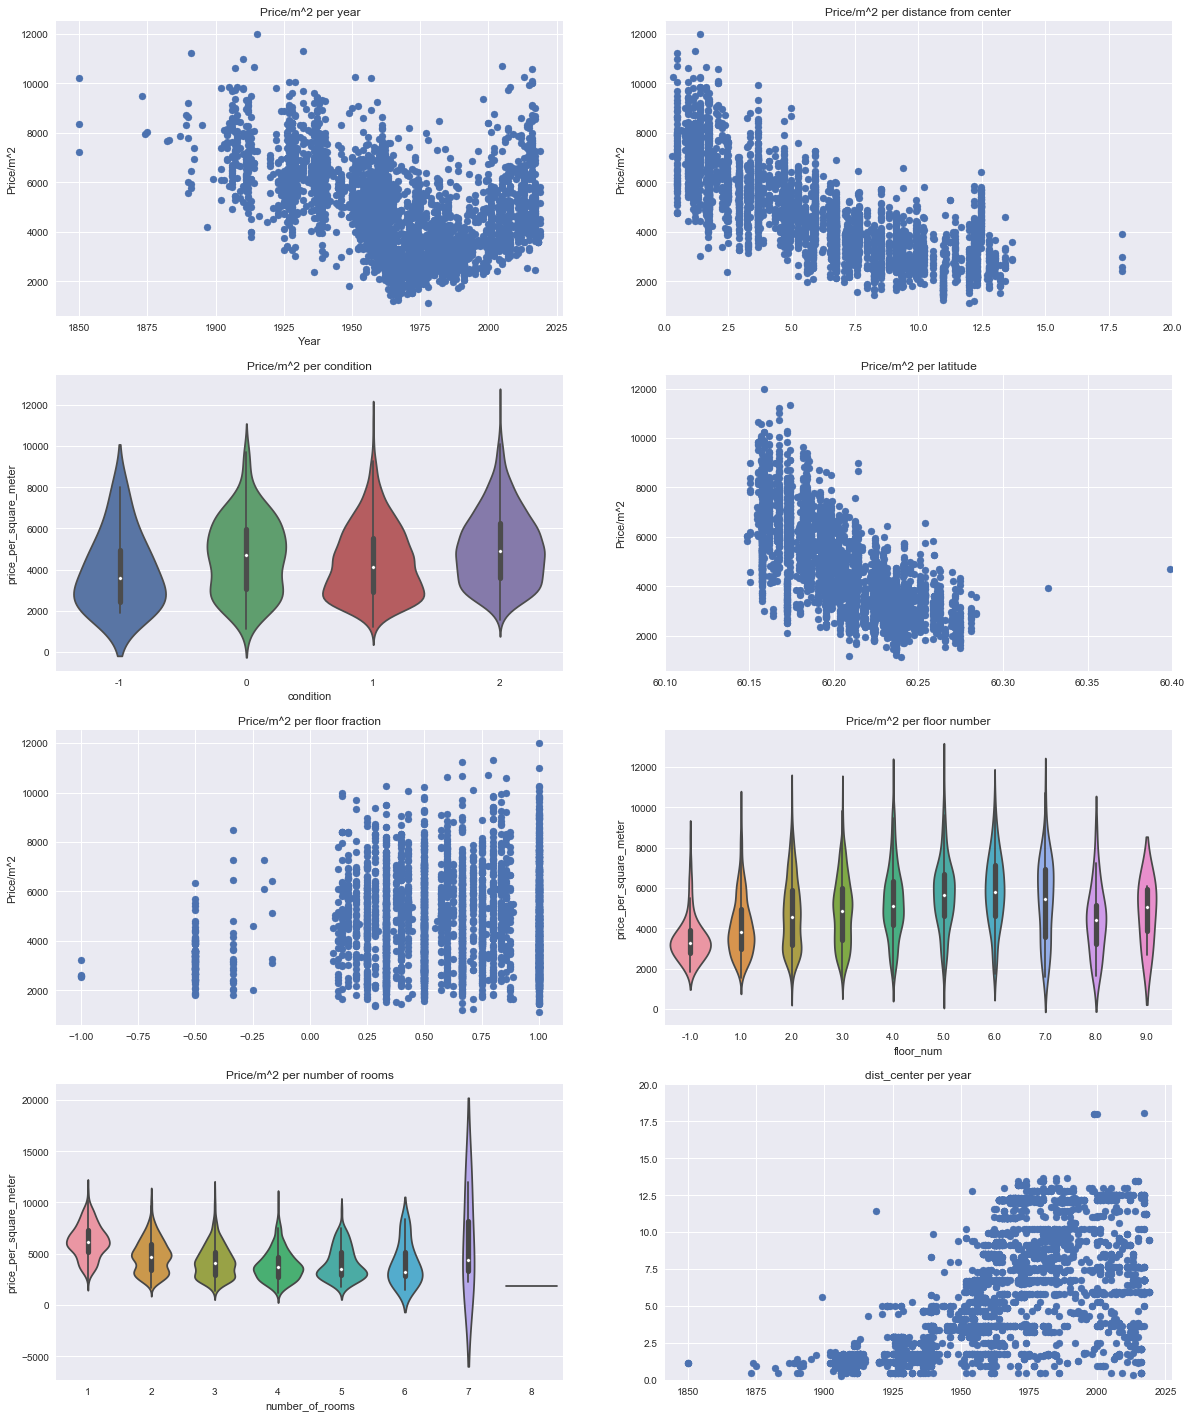

In [61]:
utils.plot_variables(data)

### Correlation plot
Correlation plot gives nice overview of the variable correlations. Interesting observations include that price per square meter and price differ on a number of variables, such as house type. This is again result from the fact that different house types are inherently of different sizes, and that price per square meter and square meters is negatively correlated.

Floor number is also positively correlated. It can perhaps be seen more clearly from the plots above but apartments higher up fetch a higher price.

Some correlations are obvious, such as elevator fetching a high price, elevator correlating with floor number, and condition correlating with price and price per square meter.

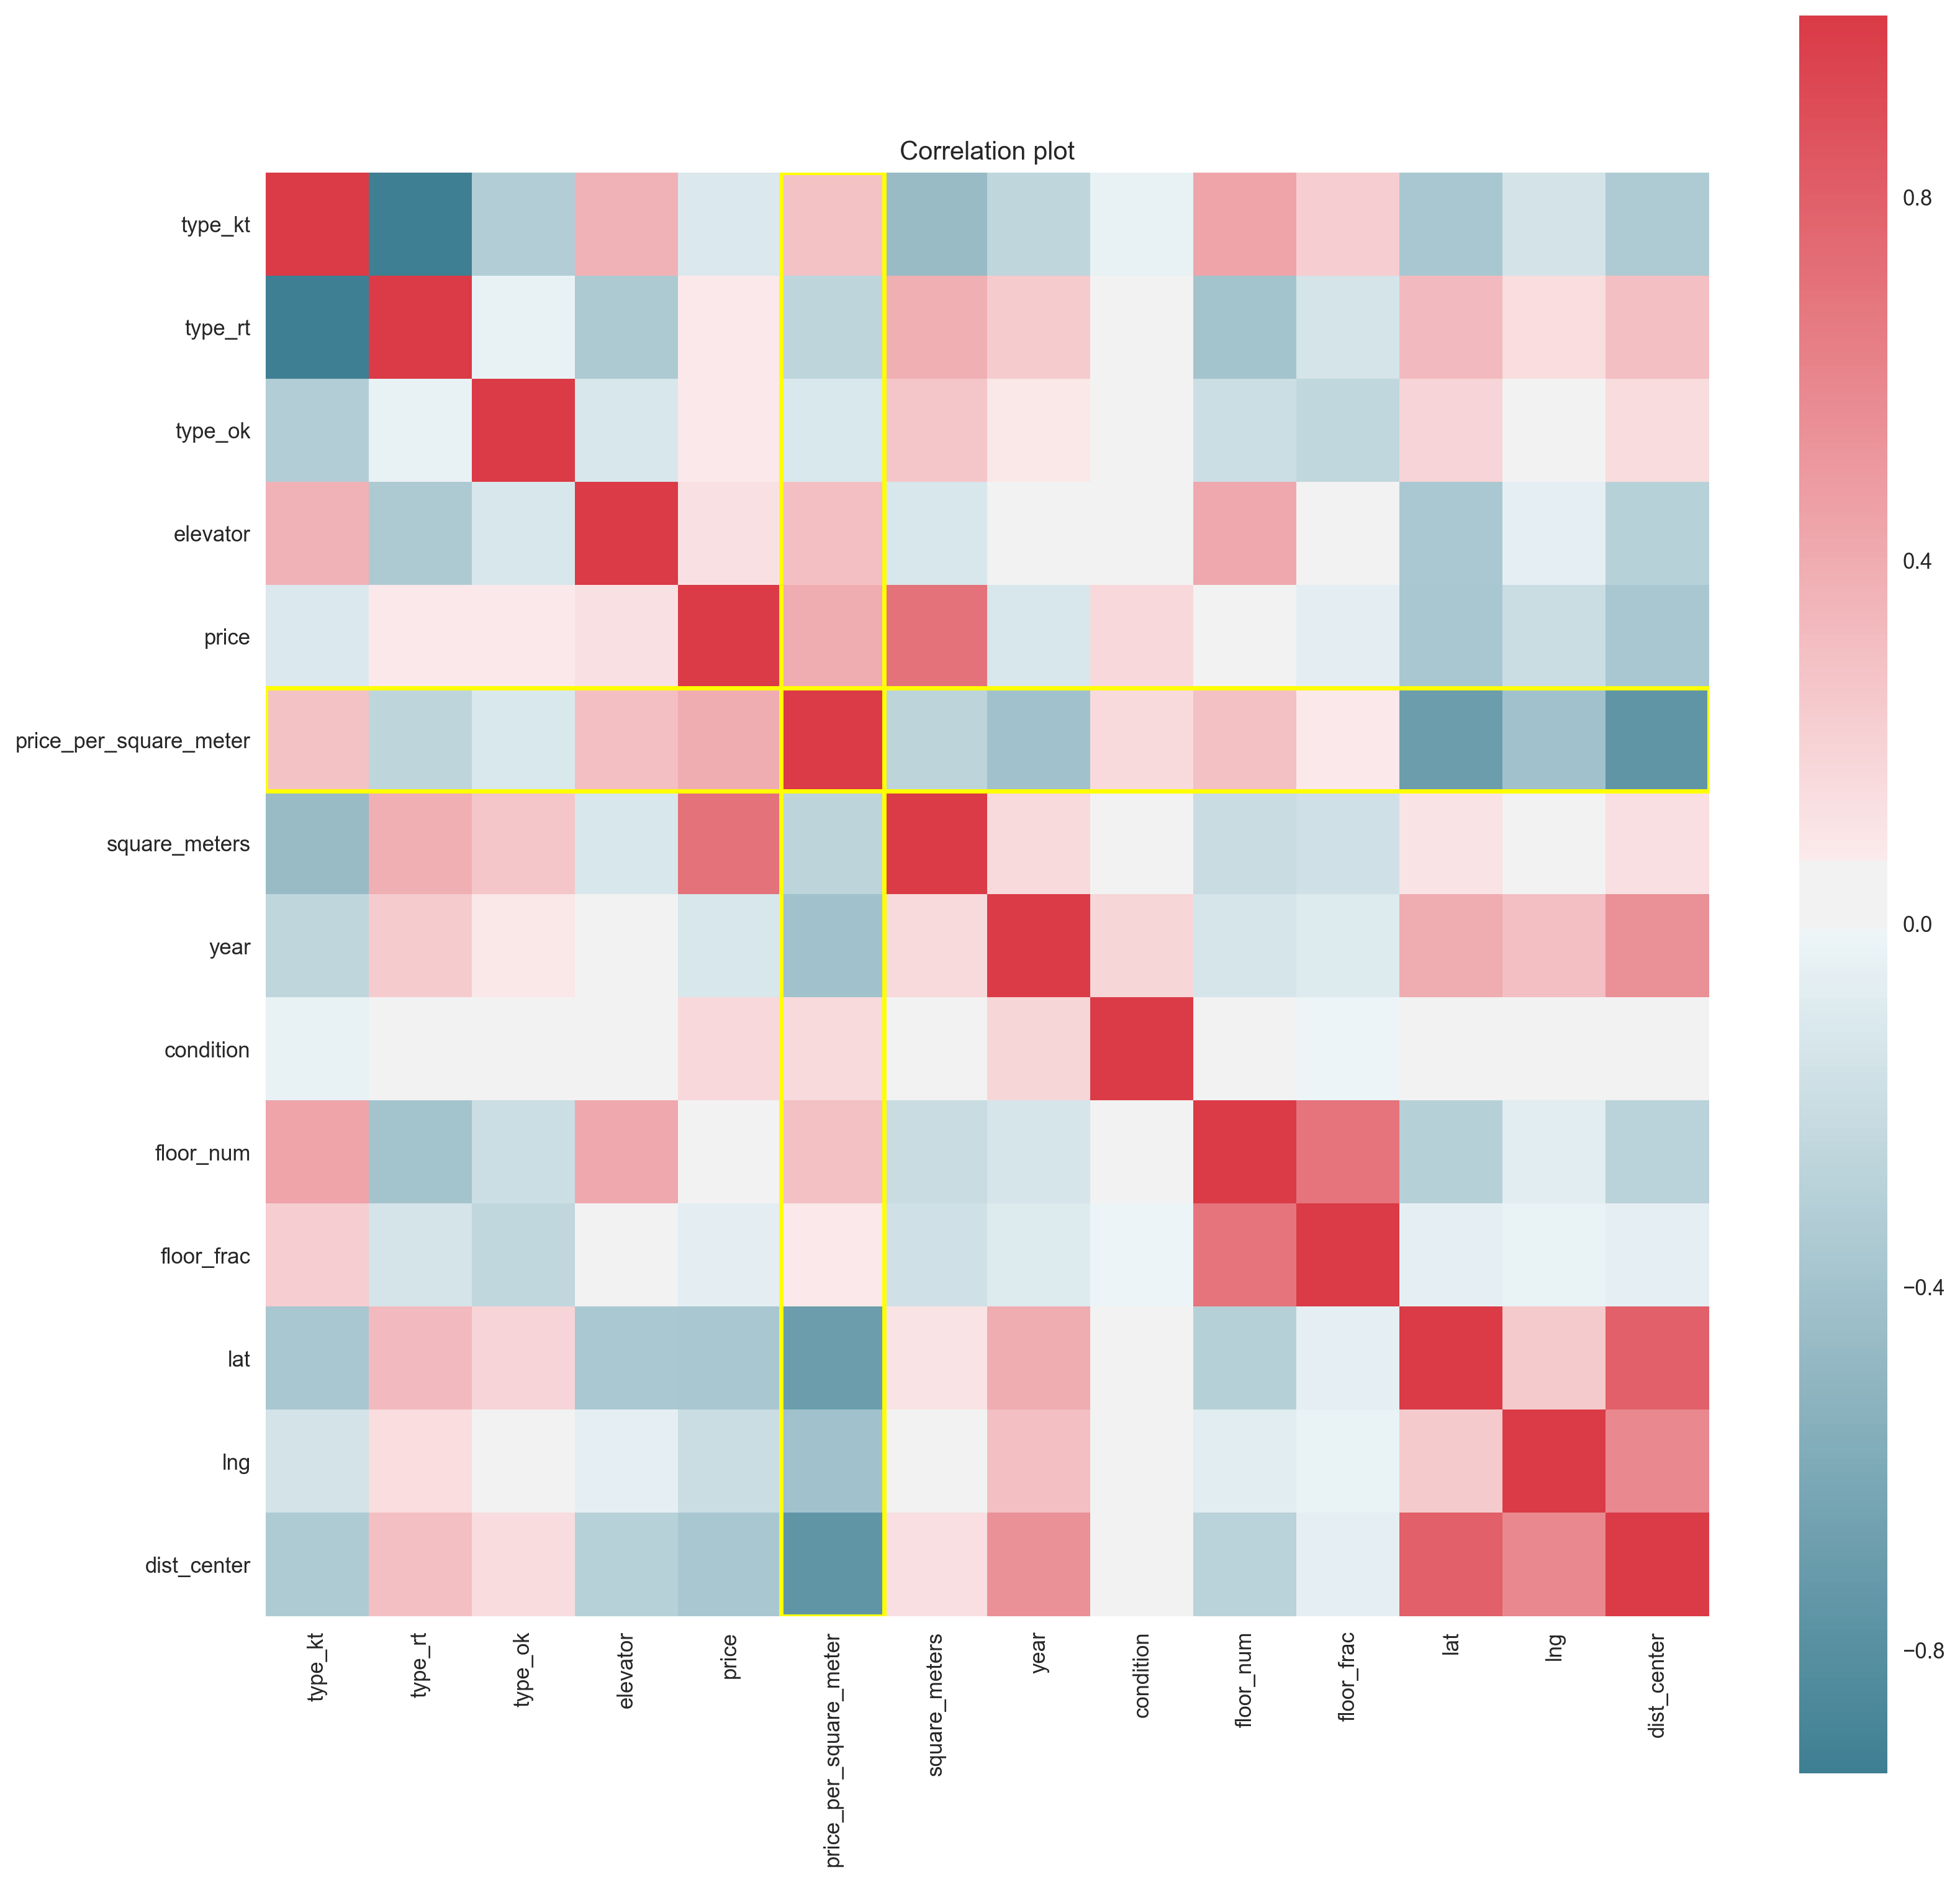

In [62]:
utils.plot_correlation(data)

### TSNE embedding
Next, we do tsne embedding to visualize the whole dataset in 2D. Price related variables are dropped as we wish to predict those variables and as such can use them to color the tsne plots to see if any clusters form where the price or price per square meter are different.

We plot a couple of more tsne plots where the coloring is some other interesting variable.

The resulting plots show somewhat neat clusters. In the bottom row, they are colored based on kmeans and DBSCAN clustering algorithm. By looking at the plot colored by year and the plot colored by distance we can see that some of the clusters mark older houses near the city center, other clusters recently built flats in great condition and still others cheap apartments far from the center.

The results suggest that neighbor or distance based models might perform well on this task. 

In [63]:
# TSNE, drop price and price per square meter as we want to predict those variables
data_tsne_embedded = TSNE(n_components=2).fit_transform(data.drop(columns=['price', 'price_per_square_meter']))

In [64]:
# Calculate kmeans and spectral clusters on the data for cluster visualization
kmeans = KMeans(n_clusters=8).fit(data_tsne_embedded)
kmeans_labels = kmeans.labels_

dbscan_labels = DBSCAN(eps=3).fit_predict(data_tsne_embedded)

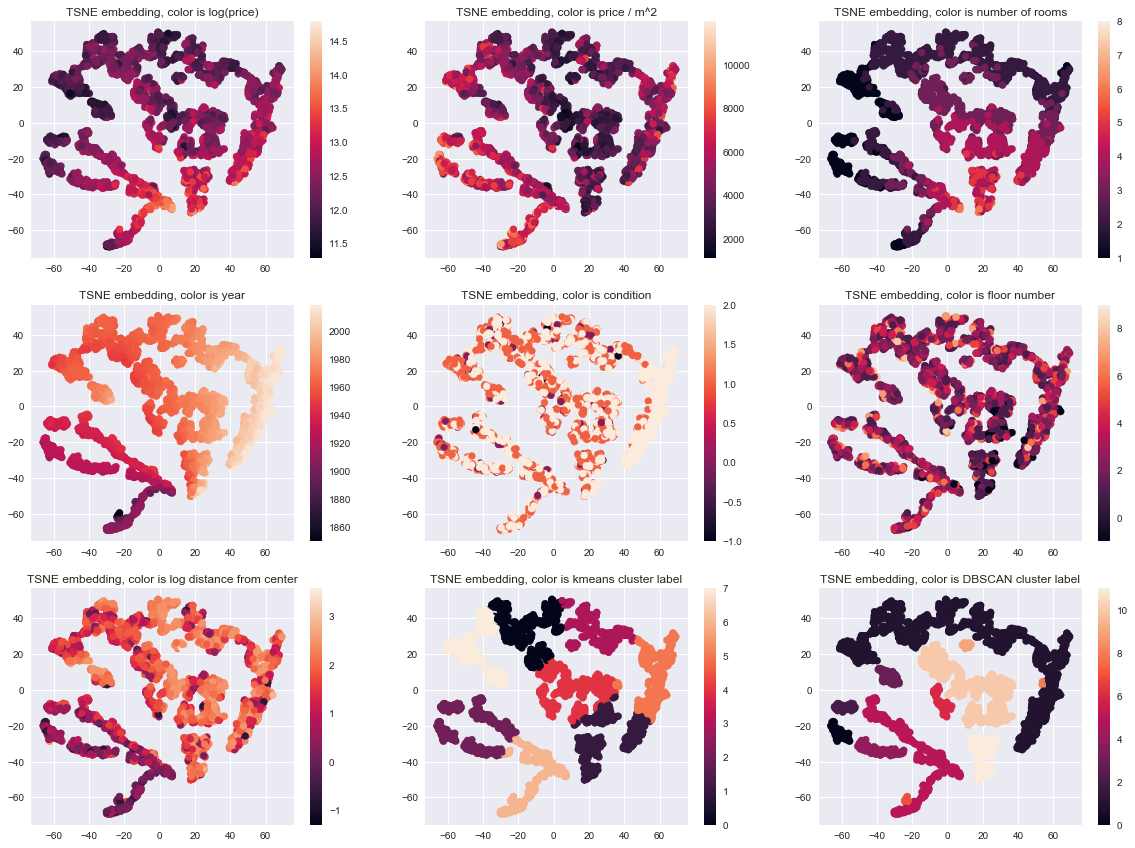

In [65]:
utils.tsne_plots(data_tsne_embedded, data, kmeans_labels, dbscan_labels)

### PCA analysis
We next do PCA analysis for the data, similarly to the TSNE embedding. We see that the first two components explain 99.1% of the variance, so most likely it would be beneficial to use just these to fit the GP. 

Explained variance for the first two principal components:
0.9925895201960611


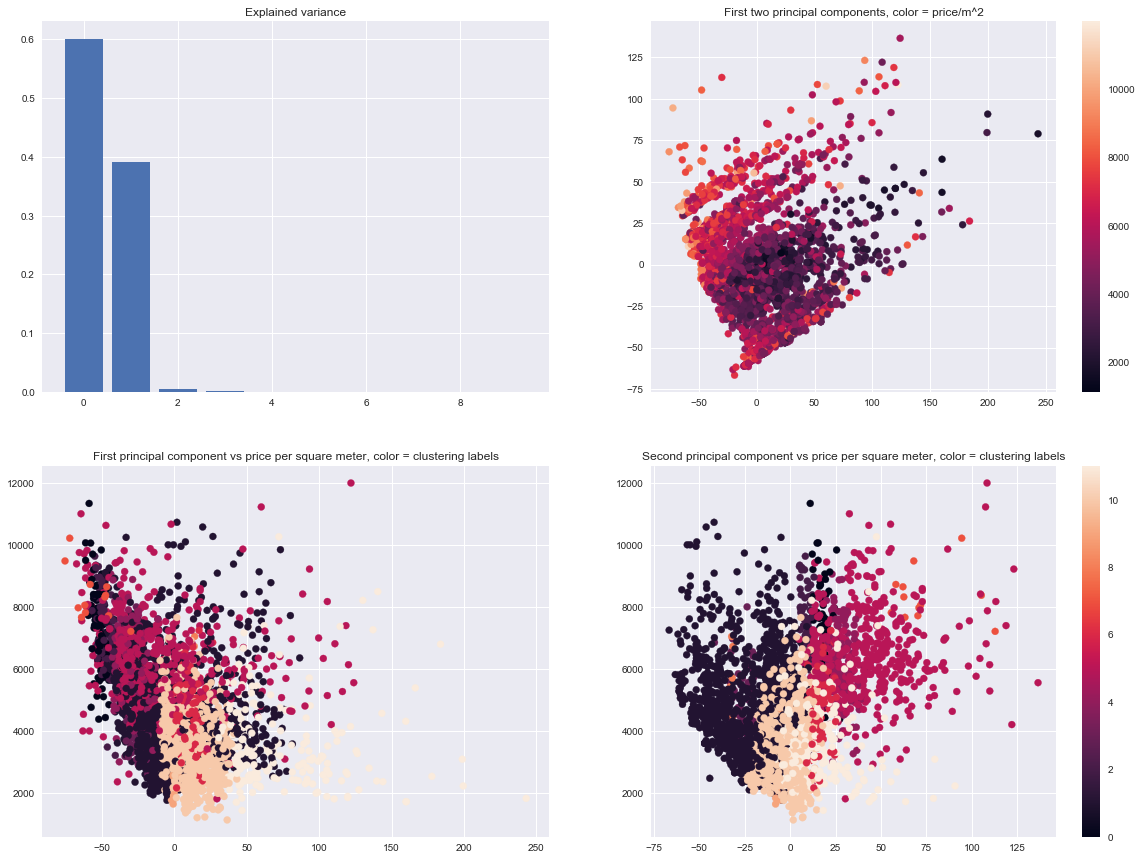

In [66]:
# TSNE, drop price and price per square meter as we want to predict those variables
pca_data = data.drop(columns=['price', 'price_per_square_meter'])

data_pca_model = PCA(n_components=10).fit(pca_data)
data_pca_embedded = PCA(n_components=10).fit_transform(pca_data)

utils.pca_plots(data_pca_model, data_pca_embedded, data, dbscan_labels)

# Model fitting

### Train-test split
We split the complete data to train and test sets. The test is set to be 20% of the whole data.

In [67]:
from sklearn.model_selection import train_test_split
# Split data to train and test sets
# Predict house prices after 2017
cutoff_year = 2000

train_data = data[data.year < cutoff_year]
test_data = data[data.year >= cutoff_year]
train_data, test_data = train_test_split(data, test_size=0.20, random_state=42)


print('Train and test set sizes:')
print(len(train_data), len(test_data))

Train and test set sizes:
2661 666


### Baseline predictions based on mean neighborghhood price per square meter

As an absolutely naive approach to get a baseline result, we calculate the mean for every neighborhood in the data set and use these to predict house prices. The results are actually pretty good, indicating that the location or neighborhood of the house plays a significant role in the pricing.

In [68]:
train_neigh, test_neigh = train_test_split(data_with_neighborhood, test_size=0.33, random_state=42)

train_neigh = train_neigh[['neighborhood','price_per_square_meter']].groupby('neighborhood').mean()
res_neigh = test_neigh.join(train_neigh, lsuffix='', rsuffix='_pred', on='neighborhood')

predictions = res_neigh['price_per_square_meter_pred']
Y_test_b = res_neigh['price_per_square_meter']

mean_test_error = np.mean((Y_test_b-predictions)**2)
mean_abs_test_error = np.mean(abs((Y_test_b - predictions)))
print('\nMean squared test error:')
print(mean_test_error)
print('\nMean absolute test error:')
print(mean_abs_test_error)
print('\n')
res_neigh[['neighborhood','price_per_square_meter','price_per_square_meter_pred']].head(5)


Mean squared test error:
934263.6491422148

Mean absolute test error:
738.4129822895227




neighborhood  price_per_square_meter  price_per_square_meter_pred
444    Kannelmäki                    5707                  3468.190476
2931   Ullanlinna                    6872                  7665.196429
3303    Siltamäki                    2722                  2672.800000
1106   Roihuvuori                    4610                  4043.829787
1475  Keski-Töölö                    6563                  6177.440000

### Baseline models

As a baseline to reach, we train kNN, Random Forest and linear regression models. We try to surpass the performance of these models with the GPs.
They both have similar MSEs, about 300 000. We can also look at the random forest's feature importances to see which features influence the decisions the most.

Random Forest model performs the best of these models, with mean absolute error of 478 and MSE of 465685. This is better than the neighborhood-based predictions, but not significantly. K-neighbors regression and linear regression produce results close to the neighborhood predictions, which might be expected as the neighborhood prediction is a kind of nearest neighbor predictor.

Of the Random Forest's feature importances, distance from city center is the most important feature by far. Square meters and year are the next most important features. Other features contribute little if at all.

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Mean squared error: 479224.06
Mean absolute error: 475.56
Variance score: 0.86 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean squared error: 971583.25
Mean absolute error: 695.80
Variance score: 0.72 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean squared error: 1015362.90
Mean absolute error: 768.87
Variance score: 0.71 

RF feature importance


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

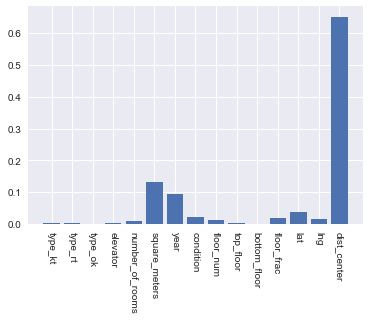

In [69]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

X_train_b = train_data.drop(columns=['price', 'price_per_square_meter'])
Y_train_b = train_data[['price_per_square_meter']]

X_test_b = test_data.drop(columns=['price', 'price_per_square_meter'])
Y_test_b = test_data[['price_per_square_meter']]

rf = RandomForestRegressor()
kn = KNeighborsRegressor()
ln = LinearRegression()


for model in [rf, kn, ln]:
    model.fit(X_train_b, Y_train_b)
    print(model)
    predictions = model.predict(X_test_b)
    print("Mean squared error: %.2f" % mean_squared_error(Y_test_b, predictions))
    print("Mean absolute error: %.2f" % mean_absolute_error(Y_test_b, predictions))
    print('Variance score: %.2f \n' % r2_score(Y_test_b, predictions))
    
print('RF feature importance')

plt.bar(range(0,15), rf.feature_importances_, tick_label = X_train_b.columns)
plt.xticks(rotation=-90)

### Baseline models for PCA data

Next we test our hypothesis that using the PCA data would be beneficial as the dimensionality is reduced to just two dimensions while retaining 99% of the variance, which should make the models simpler and as such better as per Occam's razor.

This does not seem to be the case here, however, as the errors increase significantly with all models. This might be a problem with our experiment setup, but at this point we decided to drop our original plan of predicting housing prices using all variables and focus on deeper exploration of how different variables affect the housing prices. Along with this decision, the PCA based model idea was also dropped.  

In [70]:
data_pca_model = PCA(n_components=2).fit(pca_data)

# Construct pca train test sets
pca_train_X = data_pca_model.transform(train_data.drop(columns=['price', 'price_per_square_meter']))
pca_train_Y = np.array(train_data['price_per_square_meter'])[:, None]

pca_test_X = data_pca_model.transform(test_data.drop(columns=['price', 'price_per_square_meter']))
pca_test_Y = np.array(test_data['price_per_square_meter'])[:, None]

rf = RandomForestRegressor()
kn = KNeighborsRegressor()
ln = LinearRegression()


for model in [rf, kn, ln]:
    model.fit(pca_train_X, pca_train_Y)
    print(model)
    predictions = model.predict(pca_test_X)
    print("Mean squared error: %.2f" % mean_squared_error(pca_test_Y, predictions))
    print("Mean absolute error: %.2f" % mean_absolute_error(pca_test_Y, predictions))
    print('Variance score: %.2f \n' % r2_score(pca_test_Y, predictions))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
Mean squared error: 1759464.97
Mean absolute error: 973.24
Variance score: 0.50 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')
Mean squared error: 1696304.40
Mean absolute error: 971.99
Variance score: 0.52 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Mean squared error: 2658709.31
Mean absolute error: 1301.88
Variance score: 0.24 



/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



# Variable exploration

Instead of trying to just fit various models to the data to predict housing prices, we now move to explore some of the more interesting variables. Our aim is to model them and gain insights of the process of how the prices actually work. 

We start with exploring how the year built variable affects housing prices.

## Linear regression

We first model the variables with simple linear regression models to get baselines. We try different orders of linear regression.

### Year built

We fit three linear models, with up to third order polynomial transforms. The first order polynomial fit is quite bad, as it does not capture the trend of newer houses costing more than houses built between 1960-1980. Second and third order polynomials are almost identical, and both fit the data nicely.

Our findings here are that Older 

In [71]:
reload(utils)
x_train = train_data[['year']]
y_train = train_data['price_per_square_meter']

x_test = test_data[['year']]
y_test = test_data['price_per_square_meter']

utils.plotLinearData(x_train, y_train, x_test, y_test, 3)

Linear regression fit of order 1
Coefficients: 
 [  0.         -24.79782477]
Mean squared error: 2860640.79
Mean absolute error: 1355.61
Variance score: 0.18


Linear regression fit of order 2
Coefficients: 
 [ 0.00000000e+00 -2.65742471e+03  6.70567047e-01]
Mean squared error: 2293973.11
Mean absolute error: 1205.63
Variance score: 0.34


Linear regression fit of order 3
Coefficients: 
 [ 0.00000000e+00  1.29638777e+05 -6.69640424e+01  1.15233297e-02]
Mean squared error: 2041406.63
Mean absolute error: 1118.51
Variance score: 0.42


## Distance from center
Next we move to explore the effect of distance from center on the price. Again, we fit three different polynomials to the data, and this time the first order polynomial fits almost as well as the higher orders. The negative linear trend of the distance from center is clear.

In [72]:
x_train = train_data[['dist_center']]
y_train = train_data['price_per_square_meter']

x_test = test_data[['dist_center']]
y_test = test_data['price_per_square_meter']

utils.plotLinearData(x_train, y_train, x_test, y_test, 3)

Linear regression fit of order 1
Coefficients: 
 [   0.         -357.89069098]
Mean squared error: 1379211.58
Mean absolute error: 900.14
Variance score: 0.61


Linear regression fit of order 2
Coefficients: 
 [   0.         -649.84854049   21.20329149]
Mean squared error: 1253703.49
Mean absolute error: 857.34
Variance score: 0.64


Linear regression fit of order 3
Coefficients: 
 [ 0.00000000e+00 -8.63396443e+02  4.57328133e+01 -6.65509559e-01]
Mean squared error: 1253939.03
Mean absolute error: 865.99
Variance score: 0.64


# Gaussian processes for price prediction
We now move to do these same experiments with Gaussian Processes. For clarity, we leave our initial experiments here that were done before we moved to explore just some of the variables.

Let's do this boys: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/sampling_hmc.ipynb
And some other stuff from here: http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/index.ipynb

### Year

We used x and x kernels. The result looks very much like the third order polynomial we fitted earlier, but when using Gaussian Processes we get he confidence intervals which are beneficial. The test error is also similar to the linear regression model.

In [73]:
X_train = np.array(train_data[['year']])
Y_train = np.array(train_data['price_per_square_meter'])[:, None]

X_test = np.array(test_data[['year']])
Y_test = np.array(test_data['price_per_square_meter'])[:, None]

kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=10., lengthscale=1.) 

m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)
reload(utils)
utils.model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s00  0000   2.006330e+09           nan 
    05s40  0005   4.918494e+08   8.690876e+15 
    12s78  0013   5.138947e+07   1.039652e+12 
    19s34  0020   6.792222e+06   4.872810e+08 
    23s03  0024   2.240858e+06   2.037423e+07 
    30s52  0032   2.922762e+05   2.710793e+04 
    39s86  0042   3.954426e+04   3.854778e+06 
    47s42  0050   2.387496e+04   1.074305e+02 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



    48s61  0051   2.476800e+04           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply



    53s36  0055   2.387496e+04   1.074305e+02 
Runtime:     53s36
Optimization status: Converged




Name : GP regression
Objective : 23874.95782566271
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |  383391.7466045335  |      +ve      |        
  rbf.lengthscale          |  92.88954585362904  |      +ve      |        
  Gaussian_noise.variance  |  883472.7323577921  |      +ve      |        

Log marginal likelihood:
-23874.95782566271
(666, 1)

Mean squared test error:
2153980.9974135924

Mean absolute test error: 1156.99

MLPPD:
-8.9829213494197
This is the format of your plot grid:
[ (1,1) x1,y1 ]



### GP for price prediction distance from the center

Now gaussian processes are used to explore the distance from center variable.

The fit looks plausible, and it's almost linear where the bulk of the data is. The test error is similar to the linear regression models. However, the extrapolation or unknown data when distance from center increases beyond the bulk of the training data looks significantly better than with the linear models, as the trend downwards continues as the distance grows but does not reach zero.

In [74]:
X_train = np.array(train_data[['dist_center']])
Y_train = np.array(train_data['price_per_square_meter'])[:, None]

X_test = np.array(test_data[['dist_center']])
Y_test = np.array(test_data['price_per_square_meter'])[:, None]

kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=10., lengthscale=1.) 

m = GPy.models.GPRegression(X_train, Y_train, kernel)
m.optimize(messages=True)
reload(utils)
utils.model_information(m, X_test, Y_test, plot_test_data = True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    02s33  0002   8.413406e+08   1.558721e+17 
    04s46  0004   4.356055e+08   1.486846e+16 
    14s63  0014   2.433714e+07   1.245451e+11 
    22s54  0022   4.723053e+06   2.781582e+08 
    27s90  0027   1.161668e+06   1.393826e+06 
    32s25  0031   6.545799e+05   4.137242e+05 
    38s99  0037   1.982125e+05   2.195387e+04 
    43s18  0041   7.693527e+04   8.562016e+03 
    59s67  0056   2.321470e+04   2.187112e+01 
 01m06s06  0062   2.249042e+04   1.056971e-02 
 01m09s29  0065   2.241444e+04   8.912757e-02 
 01m44s83  0098   2.236134e+04   1.385981e+01 
Runtime:  01m44s83
Optimization status: Converged




Name : GP regression
Objective : 22361.34325261887
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  1713305.0790051536  |      +ve      |        
  rbf.lengthscale          |    3.17027256947678  |      +ve      |        
  Gaussian_noise.variance  |  1101899.4027833247  |      +ve      |        

Log marginal likelihood:
-22361.34325261887
(666, 1)

Mean squared test error:
1238515.389885531

Mean absolute test error: 860.18

MLPPD:
-8.436983220328917
This is the format of your plot grid:
[ (1,1) x1,y1 ]



## GP for PCA data
Our original idea was to predict housing prices using all of the variables. This idea was abandoned, but we include the code to show what challenges we faced.

As the first two principal components account for 99% of the variance, we fit a GP to this transform. Now the GP is two dimensional, which makes constructing kernels more difficult.

The resulting predictions are worse than the baseline predictions as the PCA data can not really be separated in any coherent way without overfitting harshly. Due to this, the predictions are off by a large margin. However, the results are better than with the baseline PCA models, indicating that the GP model works in this case better and should be chosen if this setup was something we wanted to do.

In [75]:
data_pca_model = PCA(n_components=2).fit(pca_data)

# Construct pca train test sets
pca_train_X = data_pca_model.transform(train_data.drop(columns=['price', 'price_per_square_meter']))
pca_train_Y = np.array(train_data['price_per_square_meter'])[:, None]

pca_test_X = data_pca_model.transform(test_data.drop(columns=['price', 'price_per_square_meter']))
pca_test_Y = np.array(test_data['price_per_square_meter'])[:, None]

In [76]:
kernel = GPy.kern.RBF(input_dim=pca_train_X.shape[1], variance=1., lengthscale=1.) 
kernel += GPy.kern.RBF(input_dim=pca_train_X.shape[1], variance=10., lengthscale=1.) 
kernel += GPy.kern.Linear(input_dim=pca_train_X.shape[1])

m = GPy.models.GPRegression(pca_train_X, pca_train_Y, kernel)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    06s99  0004   3.054487e+08   2.037953e+15 
    17s78  0011   3.309404e+07   5.215660e+11 
    20s90  0013   1.910328e+07   1.203625e+12 
    37s79  0024   2.215198e+06   3.598518e+07 
    42s24  0027   1.122490e+06   9.127411e+06 
    57s89  0037   1.672779e+05   1.205497e+05 
 01m26s91  0056   1.018716e+05   5.946052e+04 
 01m34s45  0061   2.832084e+05   2.209018e+07 
 01m43s38  0067   3.124375e+04   8.400944e+02 
 01m57s07  0076   2.323400e+04   4.834940e-01 
 02m04s62  0081   2.274142e+04   6.315716e-01 
 02m15s34  0088   2.274028e+04   2.547122e-01 
 02m21s57  0092   2.274024e+04   4.434775e-07 
 02m23s10  0093   2.274024e+04   4.434775e-07 
Runtime:  02m23s10
Optimization status: Converged



In [77]:
utils.model_information(m, pca_test_X, pca_test_Y, plot_test_data = False)


Name : GP regression
Objective : 22740.235711801706
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  sum.rbf.variance         |    836201.9581551331  |      +ve      |        
  sum.rbf.lengthscale      |  0.23019053100082387  |      +ve      |        
  sum.rbf_1.variance       |   492141.52648931573  |      +ve      |        
  sum.rbf_1.lengthscale    |    38.41467323076331  |      +ve      |        
  sum.linear.variances     |    7666.643550228663  |      +ve      |        
  Gaussian_noise.variance  |    759801.6661451544  |      +ve      |        

Log marginal likelihood:
-22740.235711801706
(666, 1)

Mean squared test error:
1462970.8543219555

Mean absolute test error: 902.01

MLPPD:
-8.495296113200862
This is the format of your plot grid:
[ (1,1) x1,y1 ]



## GP for all variables

This experiment uses all columns of X to predict prices per square meter. The model has better performance than all of the baseline models but does not reach the Random Forest regression performance.

In [111]:
train_X = train_data.drop(columns=['price', 'price_per_square_meter'])
train_Y = np.array(train_data['price_per_square_meter'])[:, None]

test_X = test_data.drop(columns=['price', 'price_per_square_meter'])
test_Y = np.array(test_data['price_per_square_meter'])[:, None]

kernel = GPy.kern.RBF(input_dim=train_X.shape[1], variance=1., lengthscale=1.) 
#kernel += GPy.kern.Mater(input_dim=train_X.shape[1]) 
#kernel += GPy.kern.Linear(input_dim=train_X.shape[1])

m = GPy.models.GPRegression(train_X, train_Y, kernel)
m.optimize(messages=True)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    07s56  0006   8.307022e+08   4.901087e+16 
    09s76  0008   4.161601e+08   4.836035e+15 
    21s48  0019   1.421789e+07   1.523519e+10 
    28s95  0026   4.473358e+06   1.007947e+10 
    32s12  0029   2.428728e+06   1.550017e+07 
    39s69  0036   3.829732e+05   8.971199e+05 
    43s97  0040   1.532165e+05   3.897301e+05 
    51s33  0047   3.930680e+04   5.562870e+02 
 01m00s19  0055   2.294681e+04   7.339744e+00 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:

overflow encountered in true_divide

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:

overflow encountered in square



 01m01s49  0056   4.781132e+04           nan 

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:

invalid value encountered in multiply

/u/93/vuolaa2/unix/.conda/envs/capsenv/lib/python3.6/site-packages/paramz/optimization/verbose_optimization.py:160: RuntimeWarning:

invalid value encountered in less



 01m03s58  0058   2.294681e+04   7.339744e+00 
Runtime:  01m03s58
Optimization status: Converged



In [114]:
utils.model_information(m, np.asarray(test_X), test_Y, plot_test_data = False, plot_data=False)


Name : GP regression
Objective : 22946.807534476247
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  246366.76137847005  |      +ve      |        
  rbf.lengthscale          |  44.778187013360956  |      +ve      |        
  Gaussian_noise.variance  |  503991.56780217146  |      +ve      |        

Log marginal likelihood:
-22946.807534476247

Mean squared test error:
958576.4132907321

Mean absolute test error: 713.45

MLPPD:
-8.421188008742469


# Discussion

We set out to predict housing prices with Gaussian Process using data we had scraped ourselves. Significant time was spent obtaining and preprocessing the data to get an usable dataset. Visualization of the dataset revealed useful information on variable dependencies, which ultimately led us to choose to mostly concentrate on experimenting with just a few of the variables.

The course mainly taught using GPs with single dimension, so we decided to model the $price/m^2$ dependency on year and distance from center. We compared these result to baseline linear models, and turns out the results were very similar but with confidence levels.

When using only distance from center as the predictor, the GP model outperformed the baseline linear models and with quite low error as well. However, it did not reach our naive baseline (mean neighborhood $price/m^2$) performance, which is odd as the distances should be the same for same neighborhoods.

We also fit GPs and baseline models to all variables and PCA transformations. Our initial thought was that as PCA's first two components accounted for 99% of the variance, models would perform better when working on just these two dimensions rather than the complete dataset. This was not the case however, as for unknown reason both the baseline and GP models performed significantly worse on the transformed data. 

The GP fit to all variables outperformed all baseline models except the Random Forest, which still outperformed the GP by a significant margin. This might be due to the fact that many variables in the data were categorical or binary, which by definition work well with Decision tree based models, while GPs lose performance with non-continuous variables.

# Conclusion

Predicting housing prices is not easy, and we suspect adding more covariates would significantly improve predictions. Such covariates might include economic situation indicator variables or general sentiment on house buying for a given moment. However, we managed to find some good indicators for the price and these could be used when deciding what amount to ask when selling a flat.


## Random shit

In [78]:
slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(1,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]



In [79]:


slices = [-1, 0, 1.5]
figure = GPy.plotting.plotting_library().figure(3, 1, 
                        shared_xaxes=True,
                        subplot_titles=('slice at -1', 
                                        'slice at 0', 
                                        'slice at 1.5', 
                                        )
                            )
for i, y in zip(range(3), slices):
    canvas = m.plot(figure=figure, fixed_inputs=[(0,y)], row=(i+1), plot_data=False)
GPy.plotting.show(canvas, filename='basic_gp_regression_notebook_slicing_vertical')



This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]

